In [1]:
%pylab inline
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('max_columns',200)
from tqdm import tqdm_notebook as tqdm
import time
from pandas import DataFrame,Series

from sklearn.preprocessing import StandardScaler
# from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn import preprocessing

config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth = True  # 设置tf模式为按需增长模式

## Keras Libraries for Neural Networks

from keras.models import Sequential
from keras.layers import Merge
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import PReLU
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### 预处理训练集

In [2]:
data = pd.read_csv('../rawdata/train.csv')
parent_data = data.copy()
ID = data.pop('id')
y = data.pop('species')

le = LabelEncoder()
y = le.fit(y).transform(y)

transformer = StandardScaler().fit(data)
X = transformer.transform(data)

y_cat = to_categorical(y)  # one-hot

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1) # 划分10次，测试集占20%，随机数种子为1
train_index, val_index = next(iter(sss.split(X, y)))  # 划分
X_train, X_val = X[train_index], X[val_index]
y_train, y_val = y_cat[train_index], y_cat[val_index]
print "X_train dim: ",X_train.shape
print "X_val dim:   ",X_val.shape

X_train dim:  (792, 192)
X_val dim:    (198, 192)


In [8]:
nb_features = 64
X_train_r = np.zeros((len(X_train), nb_features, 3))
X_train_r[:, :, 0] = X_train[:, :nb_features]
X_train_r[:, :, 1] = X_train[:, nb_features:128]
X_train_r[:, :, 2] = X_train[:, 128:]

X_valid_r = np.zeros((len(X_val), nb_features, 3))
X_valid_r[:, :, 0] = X_val[:, :nb_features]
X_valid_r[:, :, 1] = X_val[:, nb_features:128]
X_valid_r[:, :, 2] = X_val[:, 128:]

### 预处理测试集

In [10]:
test = pd.read_csv('../rawdata/test.csv')
test_ID = test.pop('id')
X_test = transformer.transform(test)

X_test_r = np.zeros((len(X_test), nb_features, 3))
X_test_r[:, :, 0] = X_test[:, :nb_features]
X_test_r[:, :, 1] = X_test[:, nb_features:128]
X_test_r[:, :, 2] = X_test[:, 128:]

In [12]:
def one_hot_equality(one_hot_1,one_hot_2):
    assert len(one_hot_1) == len(one_hot_2), "两个one_hot长度不等"
    if argmax(one_hot_1) == argmax(one_hot_2):
        return True
    else:
        return False

### 神经网络

In [25]:
num_input = nb_features
num_classes = 99
keep_prob = 0.6
epochs = 50
banch = 1
display_steps = 1
learning_rate = 0.00001
mini_epochs = len(X_train)

print 'creating the graph...'
inputs_ = tf.placeholder(tf.float32,[None, num_input,3],name = 'inputs')
ys_ = tf.placeholder(tf.float32,[None,num_classes],name = 'labels')
keep_prob_ = tf.placeholder(tf.float32,name = 'keep')
learning_rate_ = tf.placeholder(tf.float32,name = 'learning_rate')

# conv = tf.nn.conv1d(inputs_,filters=512,stride=1,padding='SAME')
conv = tf.layers.conv1d(inputs=inputs_, filters=512, kernel_size=3,strides=1,padding='same',activation=tf.nn.relu)
pool = tf.layers.max_pooling1d(conv, pool_size=2, strides=2,padding='same')
flat = tf.contrib.layers.flatten(pool)
flat = tf.layers.dropout(flat,rate=1-keep_prob)

fc1 = tf.layers.dense(flat, 2048, activation=tf.nn.relu)
# fc1 = tf.layers.dropout(fc1, rate=1-keep_prob)
fc2 = tf.layers.dense(fc1, 1024, activation=tf.nn.relu)
# fc2 = tf.layers.dropout(fc1, rate=1-keep_prob)
logits = tf.layers.dense(fc2, num_classes, activation=tf.nn.softmax)

# loss = tf.nn.softmax_cross_entropy_with_logits(labels=ys_, logits=logits)
loss = tf.reduce_mean(-tf.reduce_sum(ys_ * tf.log(logits), reduction_indices=[1]))
optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(loss)

print 'initializing the session...'
init = tf.global_variables_initializer()
sess = tf.Session(config=config)
sess.run(init)


def testset_loss():
#     global test_loss_list
    loss_list_test = []
    predict_error_num = 0 
    for idx in range(len(X_valid_r)):
        test_input = X_valid_r[idx].reshape((1,nb_features,3))
        ys = y_val[idx].reshape(1,99)
        loss_, logit_predict = sess.run([loss,logits],feed_dict={inputs_: test_input, ys_: ys})
        if not one_hot_equality(logit_predict,ys):
            predict_error_num += 1
        loss_list_test.append(loss_)
    error_rate = predict_error_num * 1.0 / len(X_val)
#     test_loss_list.append(mean(loss_list_test))
    return mean(loss_list_test),error_rate

train_loss_list = []
test_loss_list = []
test_error_rate_list = []
for epoch in tqdm(range(epochs)):
    mini_epochs_loss_list = []
    for idx in range(mini_epochs):
        train_input = X_train_r[idx * banch : (idx + 1) * banch]
        ys = y_train[idx*banch:(idx+1)*banch].reshape((banch,num_classes))
        _, loss_ = sess.run([optimizer,loss],feed_dict={inputs_: train_input, ys_: ys, learning_rate_:learning_rate, keep_prob_:keep_prob})
        mini_epochs_loss_list.append(loss_)

    train_loss_list.append(mean(mini_epochs_loss_list))
    if (epoch + 1) % display_steps == 0:
        tmp_mean_test_lost, tmp_error_rate = testset_loss()
        test_loss_list.append(tmp_mean_test_lost)
        test_error_rate_list.append(tmp_error_rate)
        print '%d  train_loss: %f  test_loss: %f  test_error: %f'\
            %(epoch+1,train_loss_list[-1],test_loss_list[-1],test_error_rate_list[-1])

creating the graph...
initializing the session...


HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

1  train_loss: 4.027567  test_loss: 3.082134  test_error: 0.353535
2  train_loss: 2.239355  test_loss: 1.503822  test_error: 0.141414
3  train_loss: 0.950540  test_loss: 0.746765  test_error: 0.075758
4  train_loss: 0.416948  test_loss: 0.445277  test_error: 0.065657
5  train_loss: 0.210094  test_loss: 0.302066  test_error: 0.035354
6  train_loss: 0.118787  test_loss: 0.223222  test_error: 0.040404
7  train_loss: 0.071214  test_loss: 0.174799  test_error: 0.035354
8  train_loss: 0.043945  test_loss: 0.146179  test_error: 0.035354
9  train_loss: 0.027454  test_loss: 0.126856  test_error: 0.025253
10  train_loss: 0.017722  test_loss: 0.113606  test_error: 0.025253
11  train_loss: 0.011824  test_loss: 0.112794  test_error: 0.030303
12  train_loss: 0.007712  test_loss: 0.090420  test_error: 0.025253
13  train_loss: 0.042966  test_loss: 0.083252  test_error: 0.020202
14  train_loss: 0.005612  test_loss: 0.124293  test_error: 0.030303
15  train_loss: 0.004466  test_loss: 0.077326  test_error

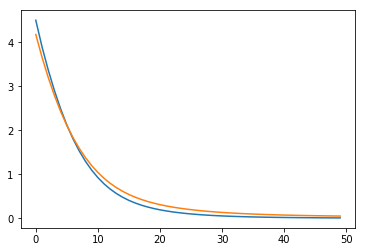

In [115]:
plot(train_loss_list)
plot(test_loss_list)

In [74]:
saver = tf.train.Saver()
model_name = 'MLP_with_given_features_insteresting_tmp_0'
save_path = saver.save(sess, '../models/'+model_name+'/save_net.ckpt')
print("Save to path: ", save_path)

('Save to path: ', '../models/MLP_with_given_features_insteresting_tmp_0/save_net.ckpt')


In [111]:
test_prediction = []
for idx in range(len(X_test)):
    test_input = X_test[idx].reshape((1,192))
    logit_predict = sess.run(logits,feed_dict={inputs_: test_input})
    test_prediction.append(logit_predict)

test_prediction = array(test_prediction).reshape((len(X_test),num_classes))

test_prediction_tmp = []
for row in test_prediction:
    tmp = argmax(row)
    test_prediction_tmp.append([1 if idx == tmp else 0 for idx in range(len(row))])

test_prediction_tmp = array(test_prediction_tmp)

test_prediction_df = DataFrame(test_prediction_tmp,index=test_ID,columns=le.classes_)

In [117]:
# 已经有softmax的
test_prediction = []
for idx in range(len(X_test)):
    test_input = X_test[idx].reshape((1,192))
    logit_predict = sess.run(logits,feed_dict={inputs_: test_input})
    test_prediction.append(logit_predict)

test_prediction = array(test_prediction).reshape((len(X_test),num_classes))
test_prediction_df = DataFrame(test_prediction,index=test_ID,columns=le.classes_)

In [118]:
test_prediction_df

,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,Alnus_Cordata,Alnus_Maximowiczii,Alnus_Rubra,Alnus_Sieboldiana,Alnus_Viridis,Arundinaria_Simonii,Betula_Austrosinensis,Betula_Pendula,Callicarpa_Bodinieri,Castanea_Sativa,Celtis_Koraiensis,Cercis_Siliquastrum,Cornus_Chinensis,Cornus_Controversa,Cornus_Macrophylla,Cotinus_Coggygria,Crataegus_Monogyna,Cytisus_Battandieri,Eucalyptus_Glaucescens,Eucalyptus_Neglecta,Eucalyptus_Urnigera,Fagus_Sylvatica,Ginkgo_Biloba,Ilex_Aquifolium,Ilex_Cornuta,Liquidambar_Styraciflua,Liriodendron_Tulipifera,Lithocarpus_Cleistocarpus,Lithocarpus_Edulis,Magnolia_Heptapeta,Magnolia_Salicifolia,Morus_Nigra,Olea_Europaea,Phildelphus,Populus_Adenopoda,Populus_Grandidentata,Populus_Nigra,Prunus_Avium,Prunus_X_Shmittii,Pterocarya_Stenoptera,Quercus_Afares,Quercus_Agrifolia,Quercus_Alnifolia,Quercus_Brantii,Quercus_Canariensis,Quercus_Castaneifolia,Quercus_Cerris,Quercus_Chrysolepis,Quercus_Coccifera,Quercus_Coccinea,Quercus_Crassifolia,Quercus_Crassipes,Quercus_Dolicholepis,Quercus_Ellipsoidalis,Quercus_Greggii,Quercus_Hartwissiana,Quercus_Ilex,Quercus_Imbricaria,Quercus_Infectoria_sub,Quercus_Kewensis,Quercus_Nigra,Quercus_Palustris,Quercus_Phellos,Quercus_Phillyraeoides,Quercus_Pontica,Quercus_Pubescens,Quercus_Pyrenaica,Quercus_Rhysophylla,Quercus_Rubra,Quercus_Semecarpifolia,Quercus_Shumardii,Quercus_Suber,Quercus_Texana,Quercus_Trojana,Quercus_Variabilis,Quercus_Vulcanica,Quercus_x_Hispanica,Quercus_x_Turneri,Rhododendron_x_Russellianum,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,1.062909e-07,1.108839e-07,5.678491e-11,2.729947e-08,8.762949e-08,3.951832e-06,2.205868e-11,3.919173e-09,6.013888e-08,1.124454e-06,7.067139e-05,6.932403e-09,3.650320e-07,7.110719e-08,6.916139e-07,8.260072e-08,9.054123e-05,1.332806e-09,1.363362e-06,4.414889e-10,8.969593e-06,4.760922e-06,7.610939e-07,3.808766e-08,1.382602e-08,2.214130e-07,3.595961e-04,4.124779e-06,2.433294e-07,4.784814e-08,2.231535e-10,1.055357e-03,5.292533e-05,8.263681e-06,9.428378e-10,8.916434e-06,6.187756e-09,3.814964e-10,6.035742e-09,7.995815e-09,1.375100e-10,1.142945e-06,3.520846e-07,1.036724e-09,3.378410e-05,3.033204e-08,6.287660e-03,1.647752e-10,1.810521e-08,2.027997e-06,3.646441e-07,9.546058e-01,2.215037e-08,1.287885e-05,1.082370e-05,5.249758e-05,1.673154e-03,4.022477e-11,3.371231e-10,3.545503e-09,1.083606e-07,9.782024e-08,6.593032e-08,4.066562e-08,1.204989e-02,1.477508e-05,1.203087e-05,2.699270e-11,2.056926e-06,1.350164e-07,7.670768e-08,7.488574e-08,3.087005e-06,4.927688e-08,9.779339e-03,2.376158e-03,1.621853e-10,6.376106e-06,1.218349e-03,2.411124e-08,1.233047e-06,2.415417e-09,1.006201e-09,9.256231e-03,1.014792e-04,1.744567e-10,3.752576e-09,2.131162e-10,7.165308e-04,9.671384e-11,1.120505e-07,8.434768e-07,1.082432e-07,2.526014e-06,2.245733e-09,4.949340e-09,6.483967e-10,1.042338e-04,4.600668e-08
7,3.188391e-08,2.977144e-08,2.229491e-06,2.709098e-04,1.667631e-10,7.201616e-08,2.348294e-05,4.763880e-09,4.062341e-08,1.118231e-09,2.538100e-10,2.148522e-10,2.301920e-08,3.959442e-09,2.628798e-09,2.507542e-08,6.224860e-09,2.122697e-06,3.632709e-09,1.771550e-04,3.473503e-09,7.432045e-09,9.357748e-09,4.220991e-09,1.104344e-09,3.212600e-09,7.916344e-07,7.203226e-07,1.335674e-07,3.196990e-08,1.042397e-06,1.068527e-06,1.663180e-07,3.714700e-10,1.778744e-05,3.292742e-11,5.435303e-04,6.561578e-07,7.225867e-06,3.619672e-05,4.933982e-05,1.723918e-05,3.577043e-06,4.919072e-06,3.333608e-08,1.151227e-04,2.778977e-11,3.397270e-04,1.432882e-06,9.054195e-10,9.957001e-01,3.613905e-09,6.093090e-07,1.030129e-07,2.267875e-08,5.337856e-06,2.666861e-10,1.446698e-06,1.511770e-04,2.560390e-05,1.331790e-06,1.130146e-06,2.621078e-09,2.655662e-05,3.047651e-09,2.342132e-09,4.

In [112]:
test_prediction_df.to_csv('../submissions/MLP_with_given_features_insteresting_tmp_0_2.csv')